# Risk Management Dashboard - Backtesting

This notebook implements backtesting methodologies to validate the accuracy of our Value-at-Risk (VaR) models. Backtesting is a critical component of model risk management that compares predicted risk measures against actual outcomes.

## Why Backtesting?

Backtesting VaR models is essential for several reasons:

1. **Model Validation**: Verifies that the VaR model accurately captures portfolio risk
2. **Regulatory Compliance**: Meets regulatory requirements for risk model validation
3. **Model Improvement**: Identifies weaknesses and areas for enhancement
4. **Confidence Building**: Builds trust in risk estimates for decision-making

## Backtesting Approaches Covered

1. **VaR Breach Analysis**: Counting and analyzing exceptions when losses exceed VaR
2. **Kupiec Test**: Statistical test of the frequency of VaR breaches
3. **Christoffersen Test**: Tests for independence of VaR breaches
4. **Combined Tests**: Evaluation of both frequency and independence
5. **Model Comparison**: Comparing the performance of different VaR methodologies

## Overview of Steps

1. Load processed portfolio returns
2. Implement rolling window backtesting
3. Apply statistical tests to evaluate VaR model accuracy
4. Analyze breach patterns and clustering
5. Compare performance of different VaR models
6. Visualize backtest results
7. Draw conclusions and recommend model adjustments
8. Save backtest results for the dashboard

In [1]:
# Import standard libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt
from scipy import stats
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

# Configure plot styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Set up project paths
PROJECT_ROOT = Path().resolve().parents[0]
CONFIG_DIR = PROJECT_ROOT / "configs"
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

# Make sure results directory exists
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Project root: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard
Processed data directory: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed
Results directory: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results


## 1. Import Backtesting Modules and Load Configuration

In [3]:
# Add the project root to the path
import sys
sys.path.append(str(PROJECT_ROOT))

# Import backtesting functions
from src.models.backtesting import (
    backtest_var_model,
    kupiec_test,
    christoffersen_test,
    combined_var_test,
    compare_var_models,
    plot_backtest_results,
    plot_breach_clustering,
    create_backtest_summary
)

# Import VaR models
from src.models.historical_var import calculate_historical_var
from src.models.parametric_var import calculate_parametric_var
from src.models.monte_carlo_var import monte_carlo_var
from src.models.expected_shortfall import calculate_expected_shortfall

# Load model configuration
with open(CONFIG_DIR / "model_config.json", 'r') as f:
    model_config = json.load(f)

# Display backtesting configuration
backtest_config = model_config.get('backtesting', {})
print("Backtesting Configuration:")
for key, value in backtest_config.items():
    print(f"  - {key}: {value}")

Backtesting Configuration:
  - window_size: 252
  - step_size: 1
  - significance_level: 0.05


## 2. Load Processed Returns Data

In [4]:
# Load portfolio returns
portfolio_file = PROCESSED_DIR / "portfolio_returns.csv"

if portfolio_file.exists():
    portfolio_returns = pd.read_csv(portfolio_file, index_col=0, parse_dates=True)
    
    # Convert to Series if it's a DataFrame with one column
    if isinstance(portfolio_returns, pd.DataFrame) and portfolio_returns.shape[1] == 1:
        portfolio_returns = portfolio_returns.iloc[:, 0]
    
    print(f"Loaded portfolio returns from {portfolio_file}")
    print(f"Portfolio returns shape: {portfolio_returns.shape}")
    print(f"Date range: {portfolio_returns.index.min()} to {portfolio_returns.index.max()}")
else:
    print(f"Portfolio returns file not found at {portfolio_file}")
    print("Please run the data cleaning notebook (02_data_cleaning.ipynb) first.")
    portfolio_returns = None

Loaded portfolio returns from /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed/portfolio_returns.csv
Portfolio returns shape: (1988,)
Date range: 2014-01-03 00:00:00 to 2022-01-21 00:00:00


Portfolio Return Statistics:
Mean: 0.000157
Std Dev: 0.013628
Min: -0.215710
Max: 0.078838
Skewness: -2.0211
Kurtosis: 33.4406


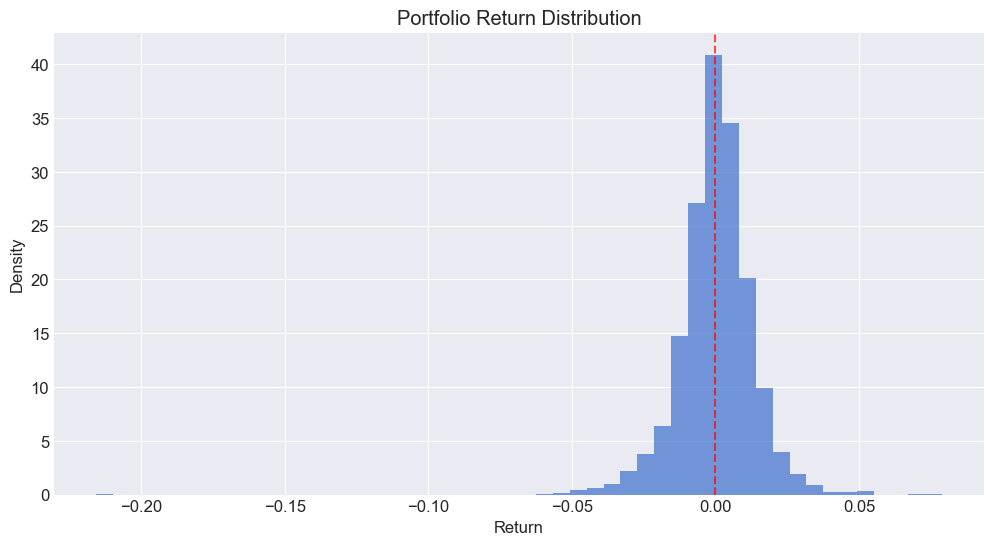

In [5]:
# Display portfolio return statistics
if portfolio_returns is not None:
    print("Portfolio Return Statistics:")
    print(f"Mean: {portfolio_returns.mean():.6f}")
    print(f"Std Dev: {portfolio_returns.std():.6f}")
    print(f"Min: {portfolio_returns.min():.6f}")
    print(f"Max: {portfolio_returns.max():.6f}")
    print(f"Skewness: {portfolio_returns.skew():.4f}")
    print(f"Kurtosis: {portfolio_returns.kurtosis():.4f}")
    
    # Plot return distribution
    plt.figure(figsize=(12, 6))
    plt.hist(portfolio_returns, bins=50, alpha=0.75, density=True)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.title('Portfolio Return Distribution')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

## 3. Set Backtesting Parameters

In [6]:
# Set backtesting parameters
if backtest_config:
    window_size = backtest_config.get('window_size', 252)
    step_size = backtest_config.get('step_size', 1)
    significance_level = backtest_config.get('significance_level', 0.05)
else:
    window_size = 252  # 1 year of trading days
    step_size = 1      # Move forward 1 day at a time
    significance_level = 0.05  # 5% significance level for tests

# Set VaR parameters
confidence_level = 0.95  # Corresponds to 5% significance level
investment_value = 1000000  # $1 million

print(f"Backtesting Parameters:")
print(f"  - Window size: {window_size} days")
print(f"  - Step size: {step_size} day(s)")
print(f"  - Significance level: {significance_level:.1%}")
print(f"  - VaR confidence level: {confidence_level:.1%}")
print(f"  - Investment value: ${investment_value:,}")

Backtesting Parameters:
  - Window size: 252 days
  - Step size: 1 day(s)
  - Significance level: 5.0%
  - VaR confidence level: 95.0%
  - Investment value: $1,000,000


## 4. Backtest Historical VaR Model

Let's start by backtesting the Historical VaR model.

Backtesting Historical VaR model...

Historical VaR Backtest Results:
Total observations: 1736
Number of breaches: 98
Breach rate: 5.65% (Expected: 5.00%)
Average VaR (% of investment): 2.03%


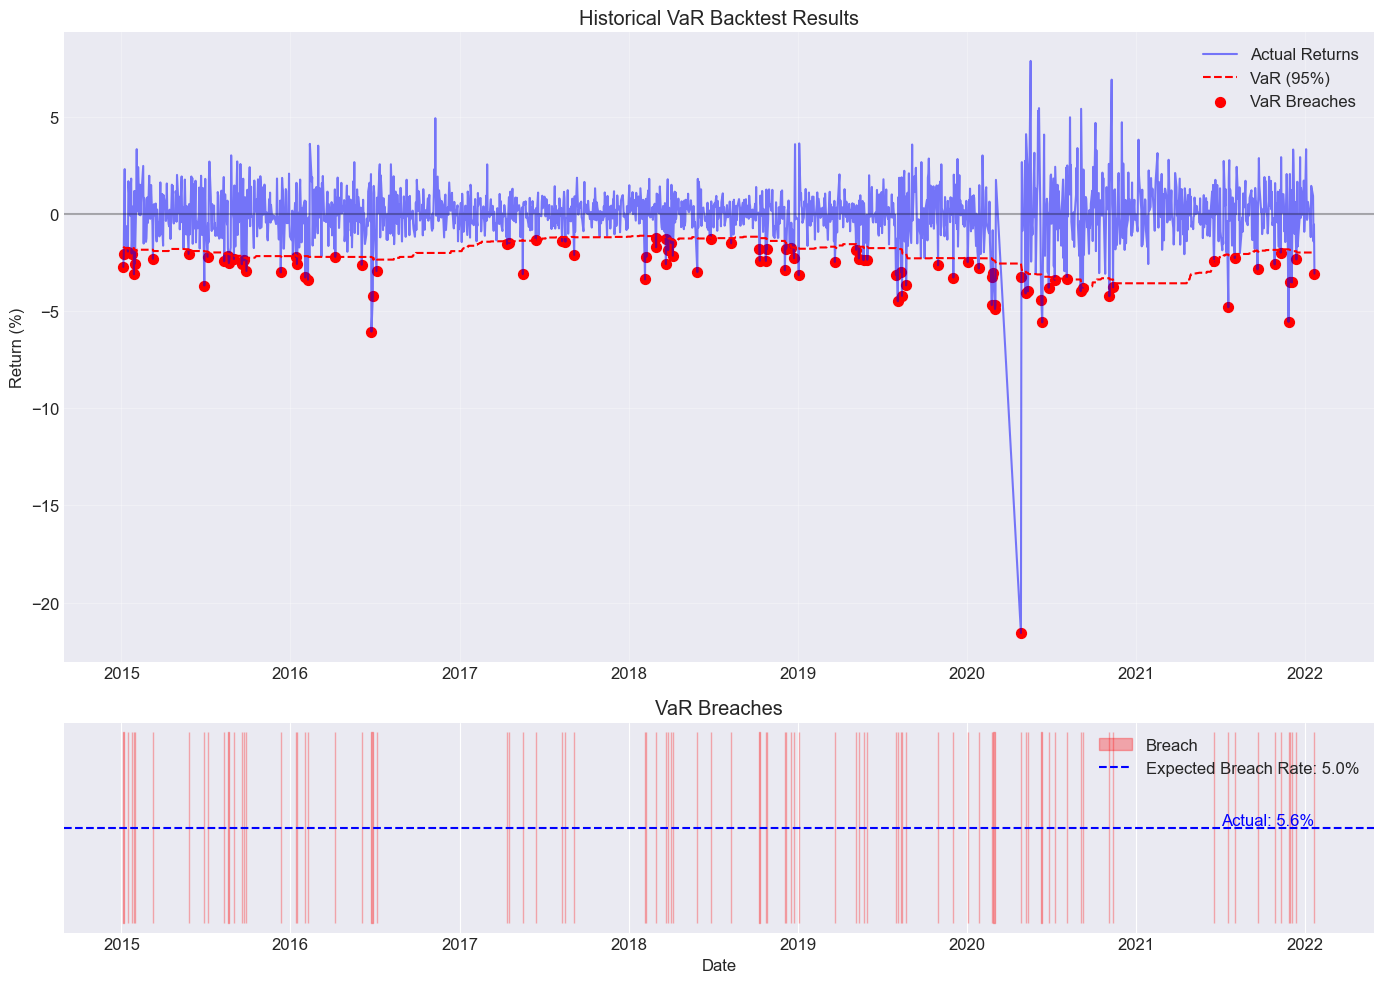

In [7]:
# Backtest Historical VaR
if portfolio_returns is not None:
    print(f"Backtesting Historical VaR model...")
    
    # Backtest Historical VaR
    hist_backtest = backtest_var_model(
        returns=portfolio_returns,
        var_model=calculate_historical_var,
        window_size=window_size,
        step_size=step_size,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    # Display backtest summary
    print(f"\nHistorical VaR Backtest Results:")
    print(f"Total observations: {len(hist_backtest)}")
    print(f"Number of breaches: {hist_backtest['breach'].sum()}")
    print(f"Breach rate: {hist_backtest['breach'].mean():.2%} (Expected: {(1-confidence_level):.2%})")
    print(f"Average VaR (% of investment): {hist_backtest['var_pct'].mean():.2%}")
    
    # Plot backtest results
    hist_var_plot = plot_backtest_results(
        backtest_results=hist_backtest,
        confidence_level=confidence_level,
        title="Historical VaR Backtest Results"
    )
    
    plt.show()


Kupiec Test (Tests correct frequency of breaches):
  - Expected breach rate: 5.00%
  - Observed breach rate: 5.65%
  - Test statistic: 1.4630
  - p-value: 0.2265
  - Result: Fail to Reject null hypothesis

Christoffersen Test (Tests independence of breaches):
  - Transition probabilities: 01->5.25%, 11->11.34%
  - Test statistic: 5.1189
  - p-value: 0.0237
  - Result: Reject (Clustered Breaches)

Combined Test:
  - Combined statistic: 6.5818
  - p-value: 0.0372
  - Result: Reject null hypothesis
  - Assessment: Model passes coverage test but fails independence test


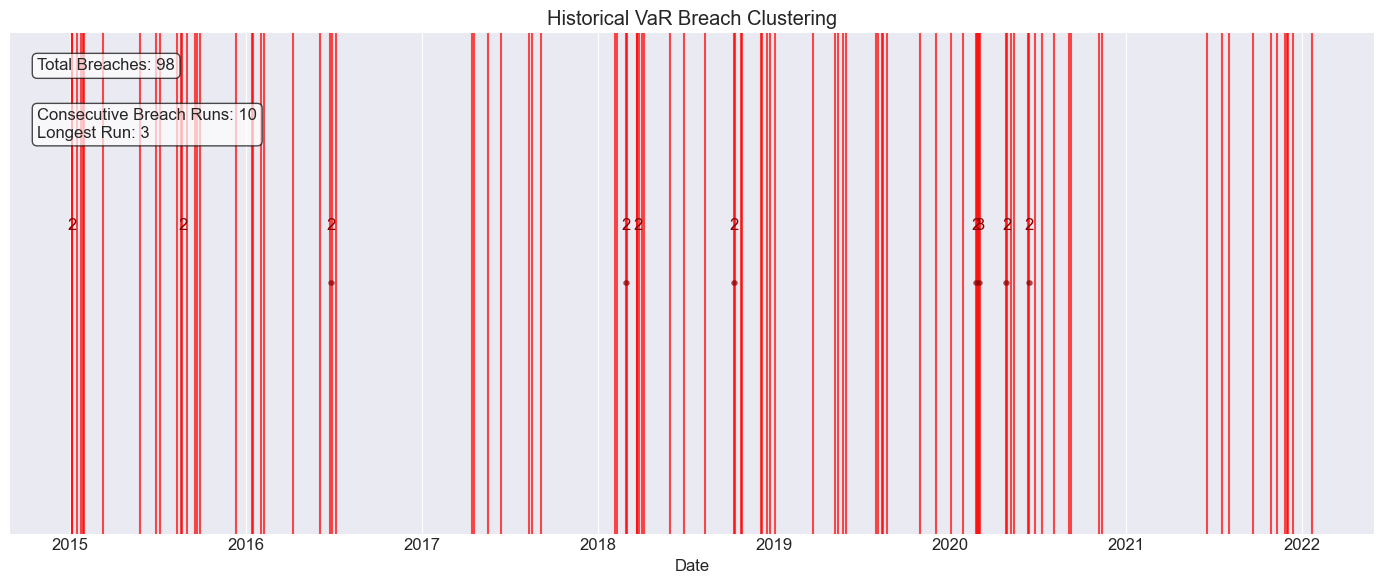

In [8]:
# Test Historical VaR model accuracy
if 'hist_backtest' in locals():
    # Get breach data
    breaches = hist_backtest['breach']
    n_observations = len(hist_backtest)
    
    # Run Kupiec test
    kupiec_results = kupiec_test(
        breaches=breaches,
        n_observations=n_observations,
        significance_level=significance_level,
        confidence_level=confidence_level
    )
    
    # Run Christoffersen test
    christoffersen_results = christoffersen_test(
        breaches=breaches,
        significance_level=significance_level
    )
    
    # Run combined test
    combined_results = combined_var_test(
        breaches=breaches,
        n_observations=n_observations,
        confidence_level=confidence_level,
        significance_level=significance_level
    )
    
    # Display test results
    print(f"\nKupiec Test (Tests correct frequency of breaches):")
    print(f"  - Expected breach rate: {kupiec_results['expected_breach_rate']:.2%}")
    print(f"  - Observed breach rate: {kupiec_results['observed_breach_rate']:.2%}")
    print(f"  - Test statistic: {kupiec_results['test_statistic']:.4f}")
    print(f"  - p-value: {kupiec_results['p_value']:.4f}")
    print(f"  - Result: {kupiec_results['result']} null hypothesis")
    
    print(f"\nChristoffersen Test (Tests independence of breaches):")
    print(f"  - Transition probabilities: 01->{christoffersen_results['probabilities']['p01']:.2%}, 11->{christoffersen_results['probabilities']['p11']:.2%}")
    print(f"  - Test statistic: {christoffersen_results['test_statistic']:.4f}")
    print(f"  - p-value: {christoffersen_results['p_value']:.4f}")
    print(f"  - Result: {christoffersen_results['result']}")
    
    print(f"\nCombined Test:")
    print(f"  - Combined statistic: {combined_results['combined_statistic']:.4f}")
    print(f"  - p-value: {combined_results['p_value']:.4f}")
    print(f"  - Result: {combined_results['result']} null hypothesis")
    print(f"  - Assessment: {combined_results['assessment']}")
    
    # Plot breach clustering
    breach_plot = plot_breach_clustering(
        backtest_results=hist_backtest,
        title="Historical VaR Breach Clustering"
    )
    
    plt.show()

## 5. Backtest Parametric VaR Model

Now let's backtest the Parametric VaR model that assumes normal distribution.

Backtesting Parametric VaR model...

Parametric VaR Backtest Results:
Total observations: 1736
Number of breaches: 95
Breach rate: 5.47% (Expected: 5.00%)
Average VaR (% of investment): 2.11%

Combined Test for Parametric VaR:
  - Assessment: Model passes coverage test but fails independence test


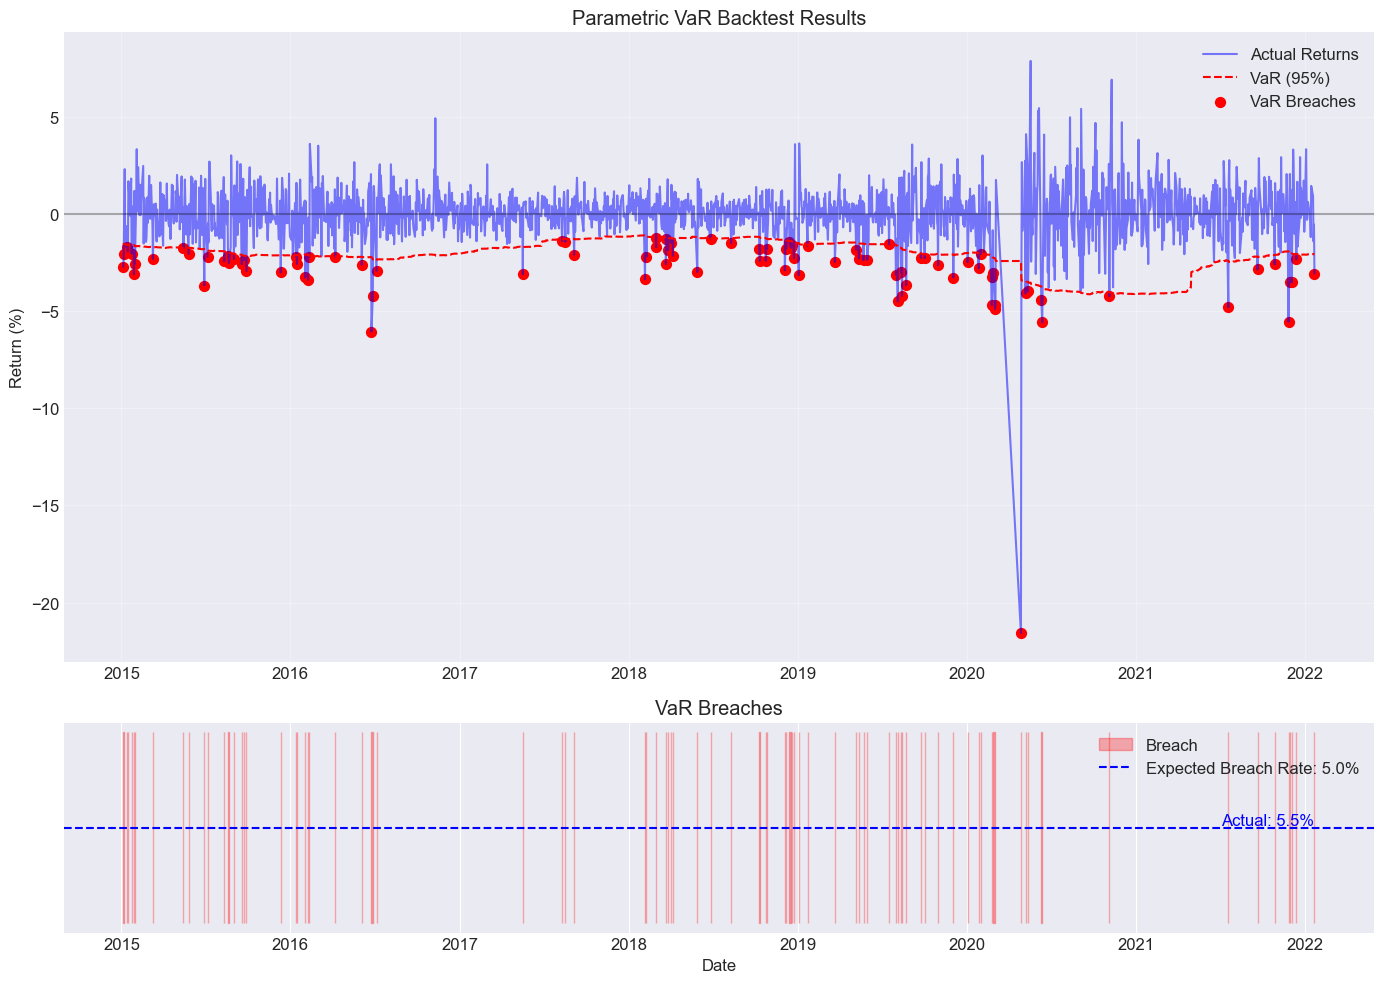

In [9]:
# Backtest Parametric VaR
if portfolio_returns is not None:
    print(f"Backtesting Parametric VaR model...")
    
    # Backtest Parametric VaR
    param_backtest = backtest_var_model(
        returns=portfolio_returns,
        var_model=calculate_parametric_var,
        window_size=window_size,
        step_size=step_size,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    # Display backtest summary
    print(f"\nParametric VaR Backtest Results:")
    print(f"Total observations: {len(param_backtest)}")
    print(f"Number of breaches: {param_backtest['breach'].sum()}")
    print(f"Breach rate: {param_backtest['breach'].mean():.2%} (Expected: {(1-confidence_level):.2%})")
    print(f"Average VaR (% of investment): {param_backtest['var_pct'].mean():.2%}")
    
    # Test Parametric VaR model accuracy
    breaches = param_backtest['breach']
    n_observations = len(param_backtest)
    
    # Run combined test
    param_test_results = combined_var_test(
        breaches=breaches,
        n_observations=n_observations,
        confidence_level=confidence_level,
        significance_level=significance_level
    )
    
    # Display test results
    print(f"\nCombined Test for Parametric VaR:")
    print(f"  - Assessment: {param_test_results['assessment']}")
    
    # Plot backtest results
    param_var_plot = plot_backtest_results(
        backtest_results=param_backtest,
        confidence_level=confidence_level,
        title="Parametric VaR Backtest Results"
    )
    
    plt.show()

## 6. Backtest Monte Carlo VaR Model

Now let's backtest the Monte Carlo VaR model.

Backtesting Monte Carlo VaR model...

Monte Carlo VaR Backtest Results:
Total observations: 348
Number of breaches: 28
Breach rate: 8.05% (Expected: 5.00%)
Average VaR (% of investment): 1.96%

Combined Test for Monte Carlo VaR:
  - Assessment: Model fails coverage test but passes independence test


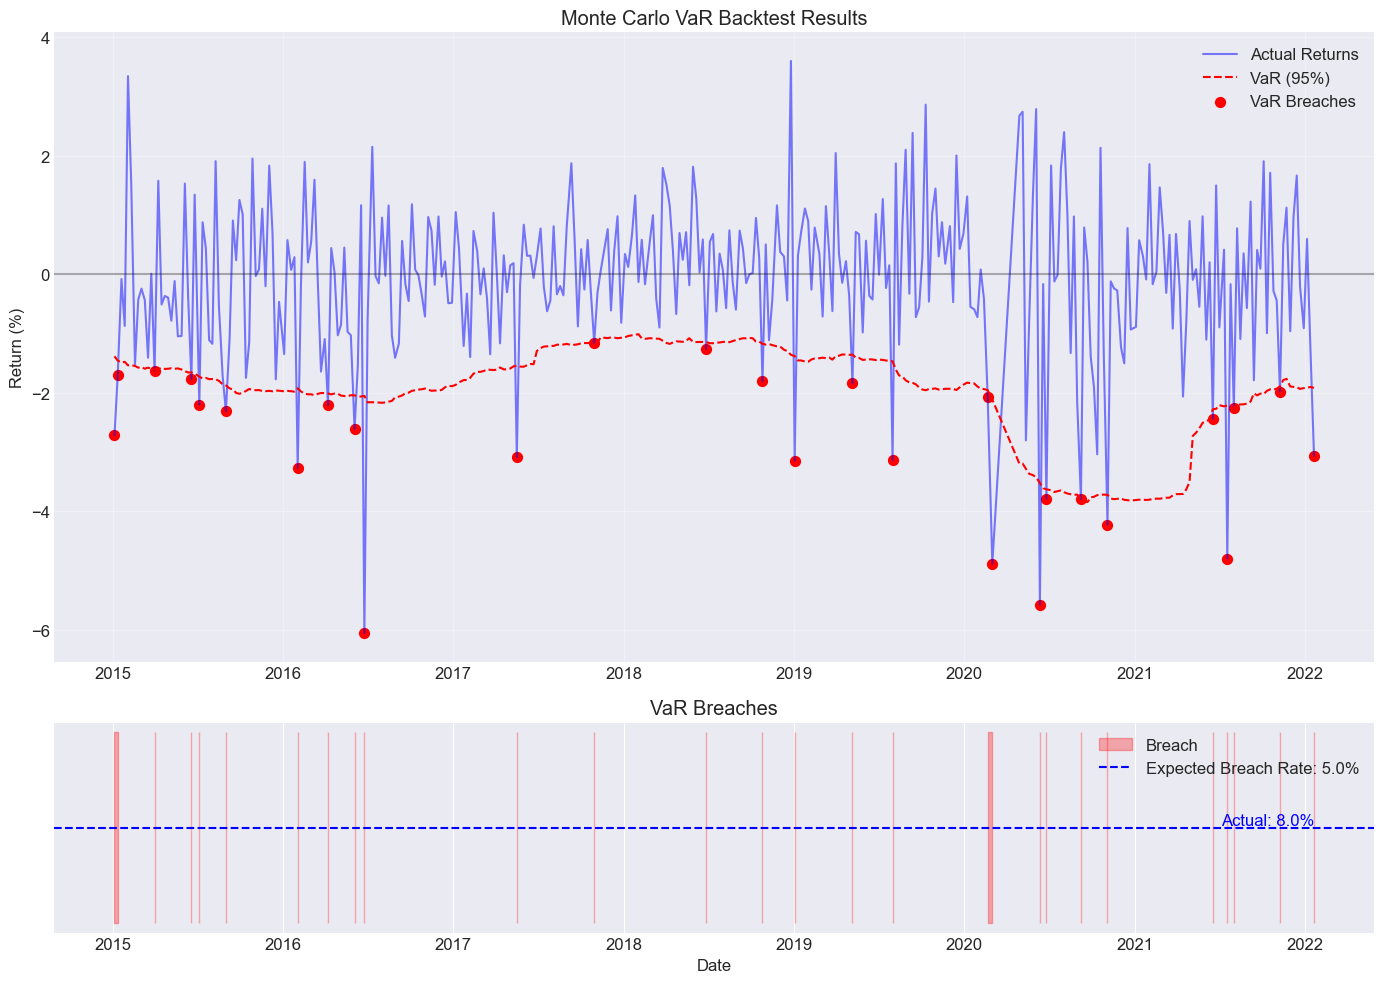

In [10]:
# Backtest Monte Carlo VaR
if portfolio_returns is not None:
    print(f"Backtesting Monte Carlo VaR model...")
    
    # Backtest Monte Carlo VaR
    # This may be slow due to simulations, so we use a smaller sample
    # and a larger step size for efficiency
    mc_step_size = 5  # Use a larger step size for Monte Carlo
    
    # Set additional parameters for Monte Carlo
    mc_params = {
        'n_simulations': 1000  # Reduce number of simulations for speed
    }
    
    mc_backtest = backtest_var_model(
        returns=portfolio_returns,
        var_model=monte_carlo_var,
        window_size=window_size,
        step_size=mc_step_size,
        confidence_level=confidence_level,
        investment_value=investment_value,
        **mc_params
    )
    
    # Display backtest summary
    print(f"\nMonte Carlo VaR Backtest Results:")
    print(f"Total observations: {len(mc_backtest)}")
    print(f"Number of breaches: {mc_backtest['breach'].sum()}")
    print(f"Breach rate: {mc_backtest['breach'].mean():.2%} (Expected: {(1-confidence_level):.2%})")
    print(f"Average VaR (% of investment): {mc_backtest['var_pct'].mean():.2%}")
    
    # Test Monte Carlo VaR model accuracy
    breaches = mc_backtest['breach']
    n_observations = len(mc_backtest)
    
    # Run combined test
    mc_test_results = combined_var_test(
        breaches=breaches,
        n_observations=n_observations,
        confidence_level=confidence_level,
        significance_level=significance_level
    )
    
    # Display test results
    print(f"\nCombined Test for Monte Carlo VaR:")
    print(f"  - Assessment: {mc_test_results['assessment']}")
    
    # Plot backtest results
    mc_var_plot = plot_backtest_results(
        backtest_results=mc_backtest,
        confidence_level=confidence_level,
        title="Monte Carlo VaR Backtest Results"
    )
    
    plt.show()

## 7. Compare Multiple VaR Models

Now let's compare the performance of different VaR models.

Comparing VaR models...

VaR Model Comparison:


,Model,Avg VaR (%),Max VaR (%),Breaches,Breach Rate (%),Expected (%),Breach Ratio,Kupiec p-value,Kupiec Test,Christoffersen p-value,Christoffersen Test,Combined Test,Assessment
0,Historical VaR,2.03,3.72,98,5.65,5.0,1.13,0.23,Fail to Reject,0.02,Reject (Clustered Breaches),Reject,Model passes coverage test but fails independe...
1,Parametric VaR,2.11,4.13,95,5.47,5.0,1.09,0.37,Fail to Reject,0.01,Reject (Clustered Breaches),Reject,Model passes coverage test but fails independe...


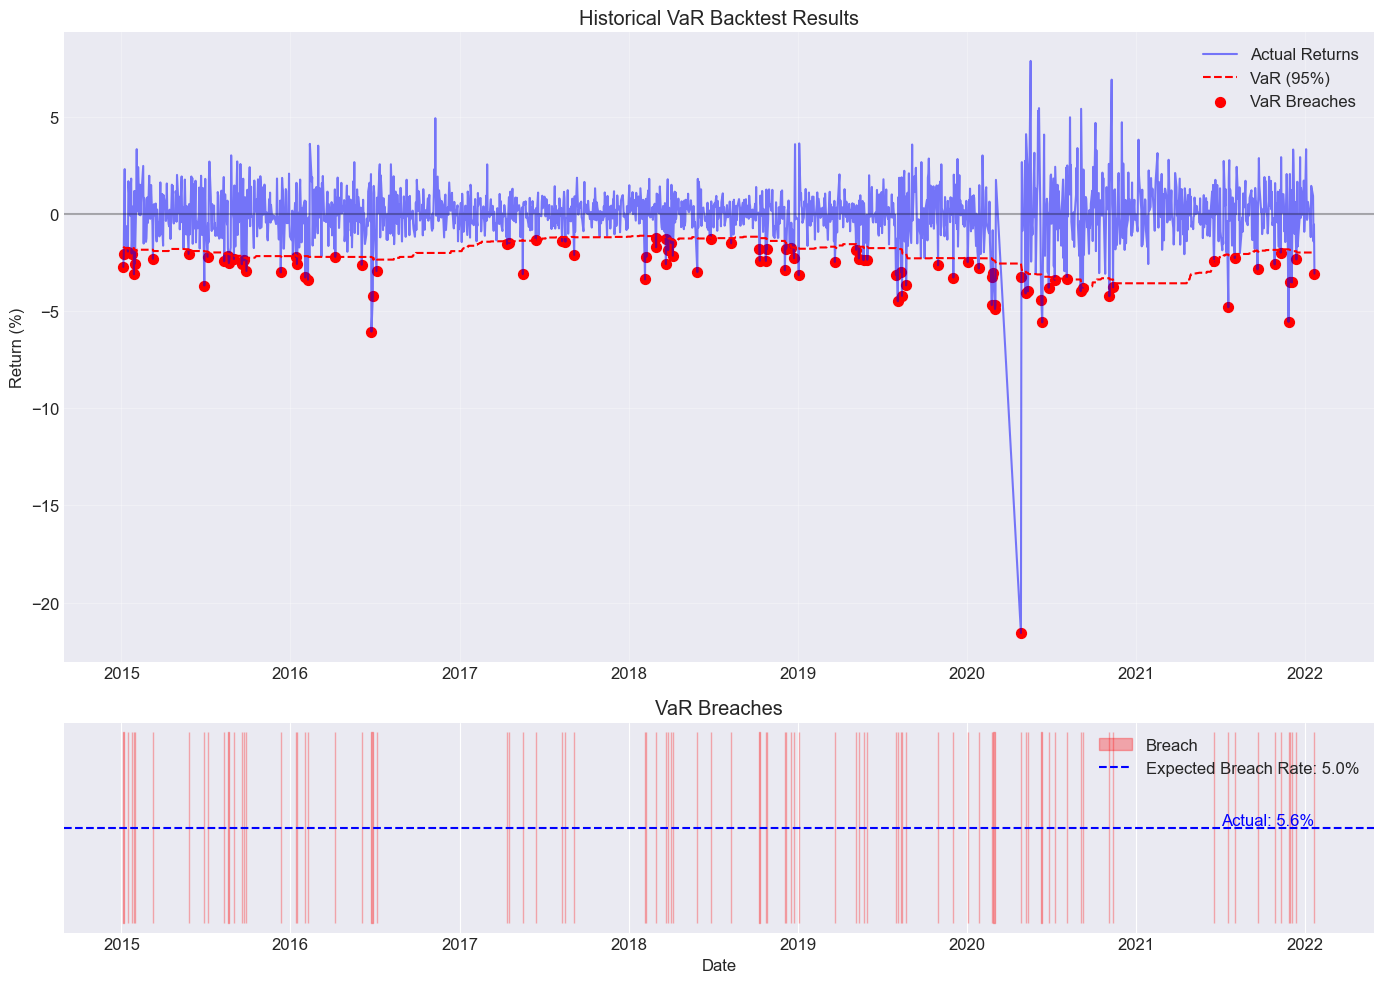

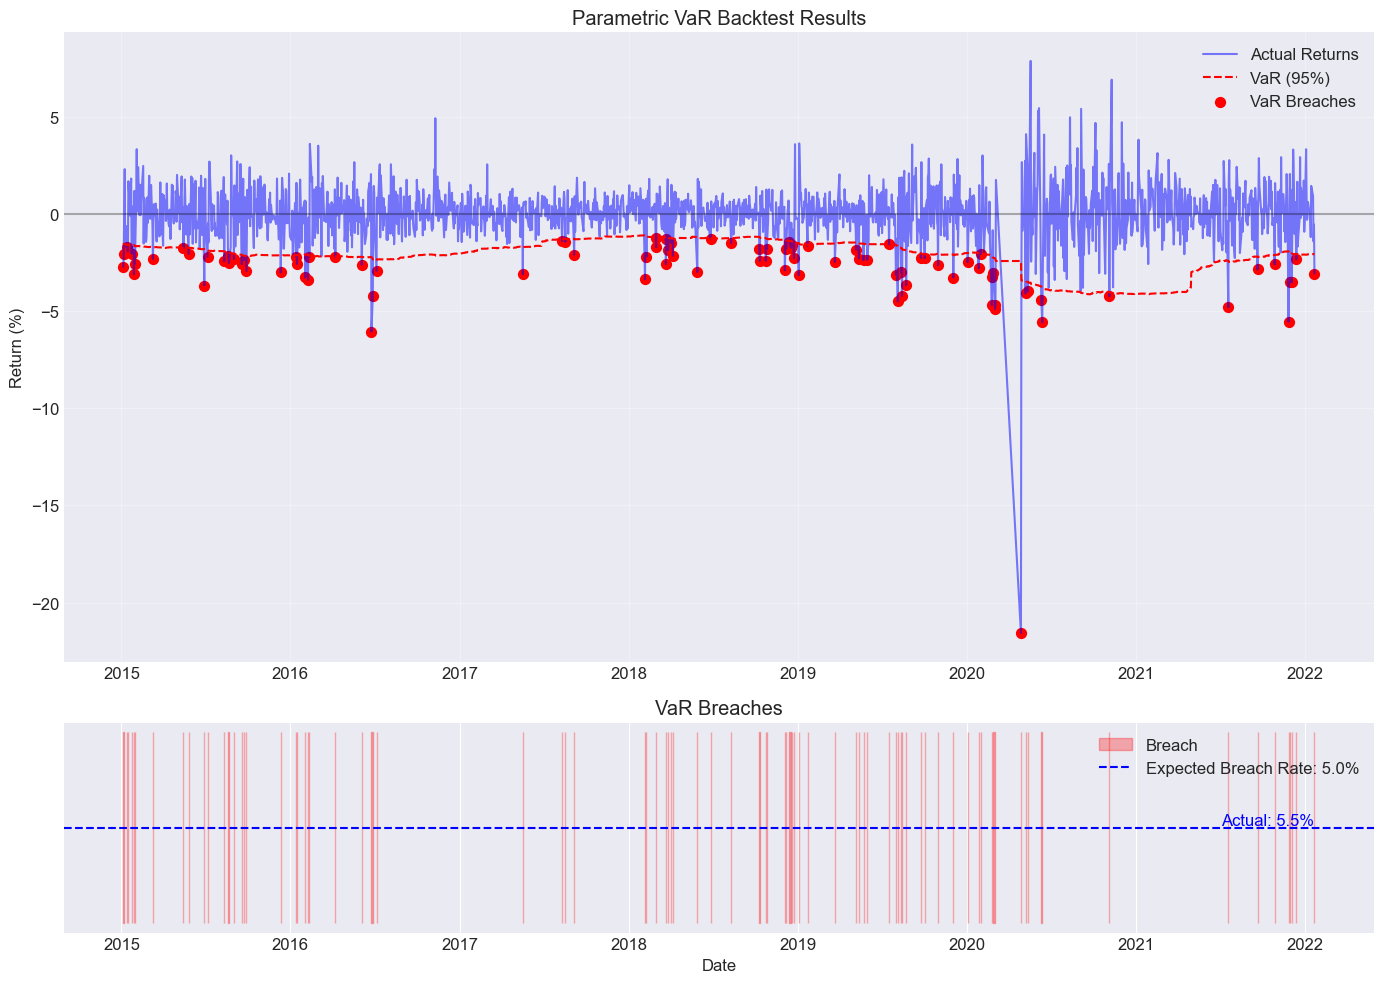

In [11]:
# Compare VaR models
if portfolio_returns is not None:
    # Define models to compare
    var_models = {
        'Historical VaR': calculate_historical_var,
        'Parametric VaR': calculate_parametric_var
    }
    
    # Note: We're excluding Monte Carlo for efficiency in this comparison
    # If you want to include it, add:
    # 'Monte Carlo VaR': monte_carlo_var
    
    print("Comparing VaR models...")
    
    # Perform model comparison
    comparison_results = compare_var_models(
        returns=portfolio_returns,
        var_models=var_models,
        window_size=window_size,
        confidence_level=confidence_level,
        investment_value=investment_value,
        significance_level=significance_level
    )
    
    # Create comparison summary
    summary = create_backtest_summary(comparison_results, confidence_level=confidence_level)
    
    # Display summary
    print("\nVaR Model Comparison:")
    display(summary)
    
    # Create comparison visualizations
    for model_name, results in comparison_results.items():
        # Show backtest plots for all models
        model_plot = plot_backtest_results(
            backtest_results=results['backtest_results'],
            confidence_level=confidence_level,
            title=f"{model_name} Backtest Results"
        )
        
        plt.show()

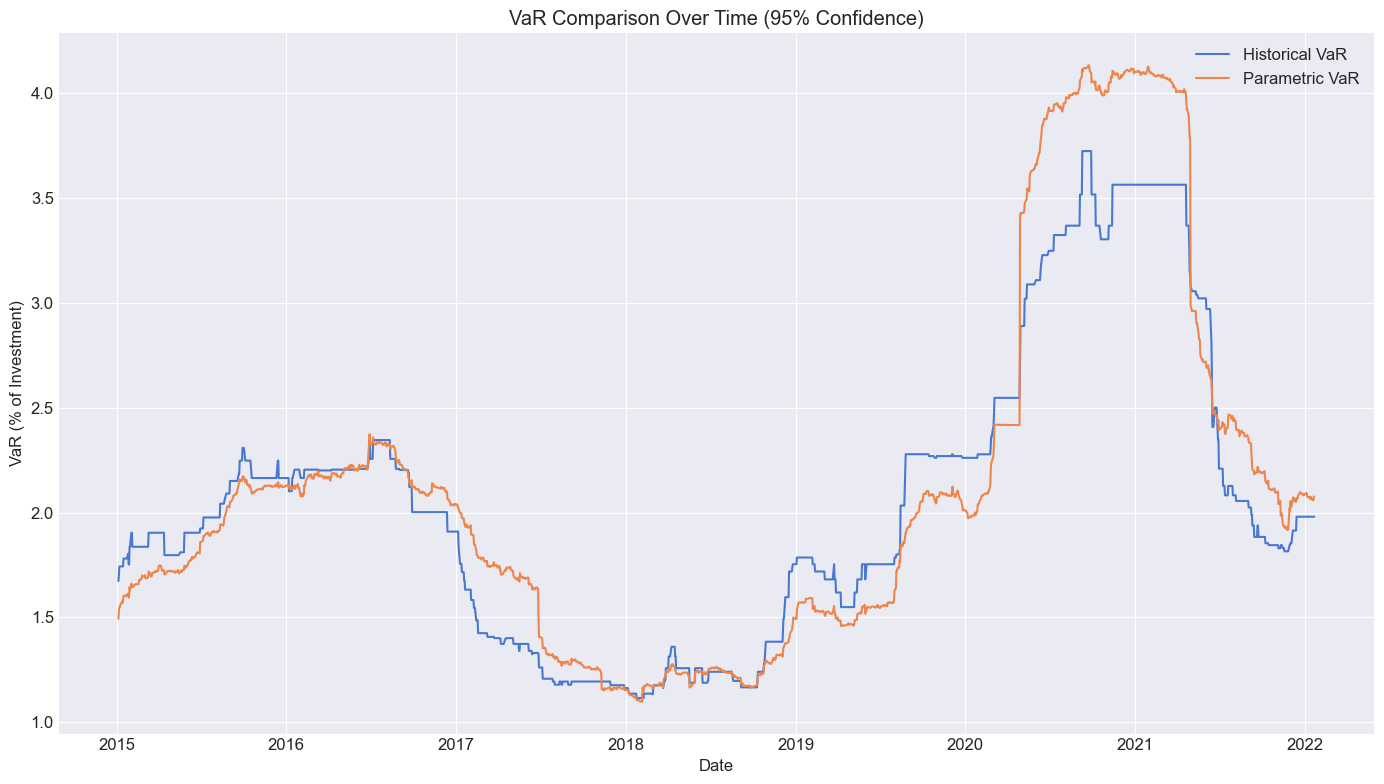

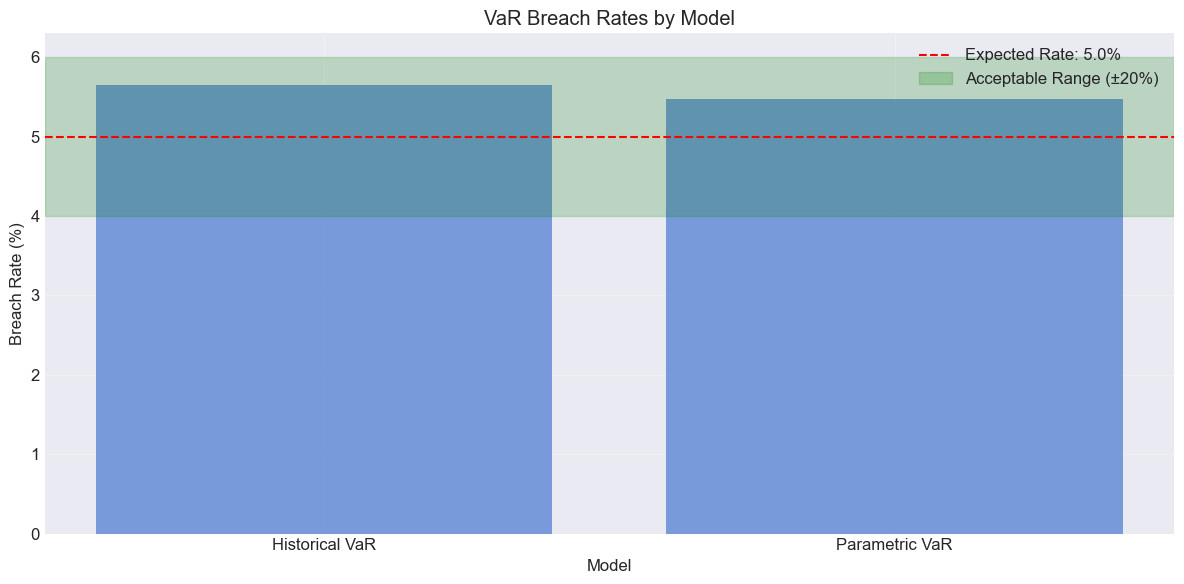

In [12]:
# Visualize VaR comparison
if 'comparison_results' in locals():
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Plot VaR over time for each model
    for model_name, results in comparison_results.items():
        backtest = results['backtest_results']
        plt.plot(backtest.index, backtest['var_pct'] * 100, label=f"{model_name}")
    
    plt.title(f"VaR Comparison Over Time ({confidence_level*100:.0f}% Confidence)")
    plt.xlabel("Date")
    plt.ylabel("VaR (% of Investment)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Compare breach rates and test results
    plt.figure(figsize=(12, 6))
    
    # Create bar chart of breach rates
    model_names = []
    breach_rates = []
    expected_rate = 1 - confidence_level
    
    for model_name, results in comparison_results.items():
        model_names.append(model_name)
        breach_rates.append(results['breach_rate'] * 100)
    
    # Create bar chart
    bars = plt.bar(model_names, breach_rates, alpha=0.7)
    
    # Add expected breach rate line
    plt.axhline(y=expected_rate * 100, color='red', linestyle='--', 
                label=f"Expected Rate: {expected_rate*100:.1f}%")
    
    # Add acceptable range (if using Basel III standards)
    lower_bound = expected_rate * 0.8 * 100
    upper_bound = expected_rate * 1.2 * 100
    plt.axhspan(lower_bound, upper_bound, alpha=0.2, color='green', 
                label=f"Acceptable Range (±20%)")
    
    plt.title("VaR Breach Rates by Model")
    plt.xlabel("Model")
    plt.ylabel("Breach Rate (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 8. Analysis of Model Performance in Different Market Regimes

Let's examine how different VaR models perform during normal and stressed market periods.

Market Regime Analysis:
Average volatility: 0.011950
High volatility threshold: 0.013851
High volatility days: 492 (24.7% of total)


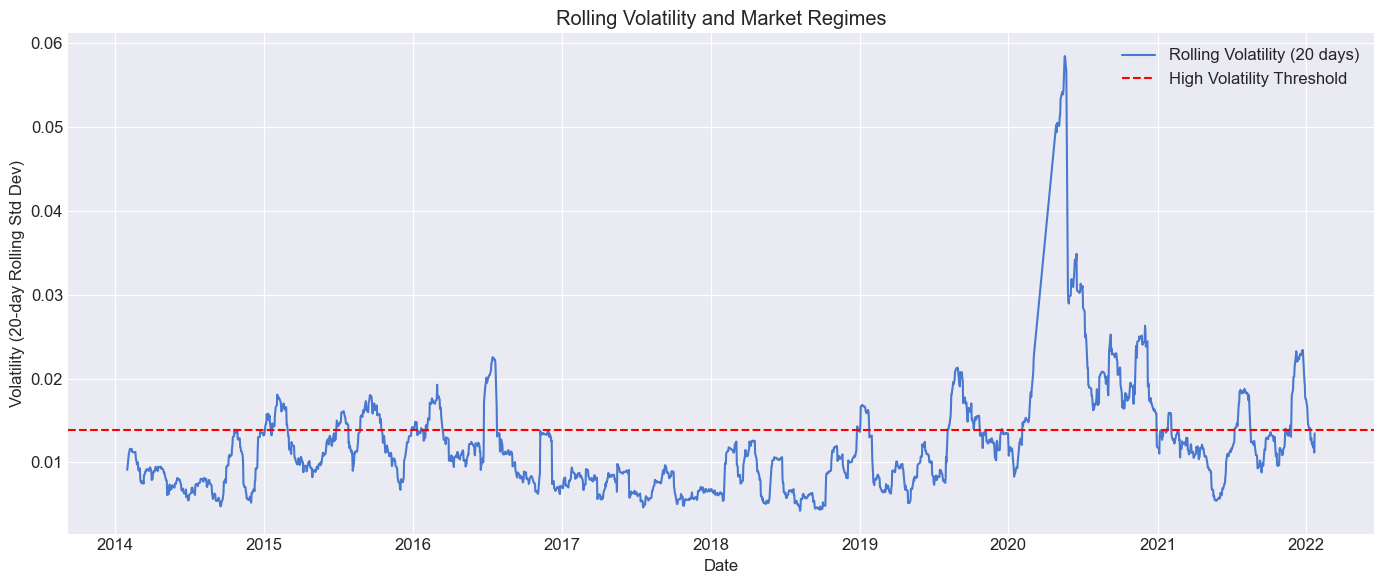


Model Performance by Market Regime:


,Model,Normal Breach Rate,Stress Breach Rate,Breach Rate Ratio,Normal VaR (%),Stress VaR (%),VaR Ratio
0,Historical VaR,0.0425,0.0918,2.1590,1.8295,2.5558,1.3970
1,Parametric VaR,0.0425,0.0857,2.0151,1.8660,2.7271,1.4615


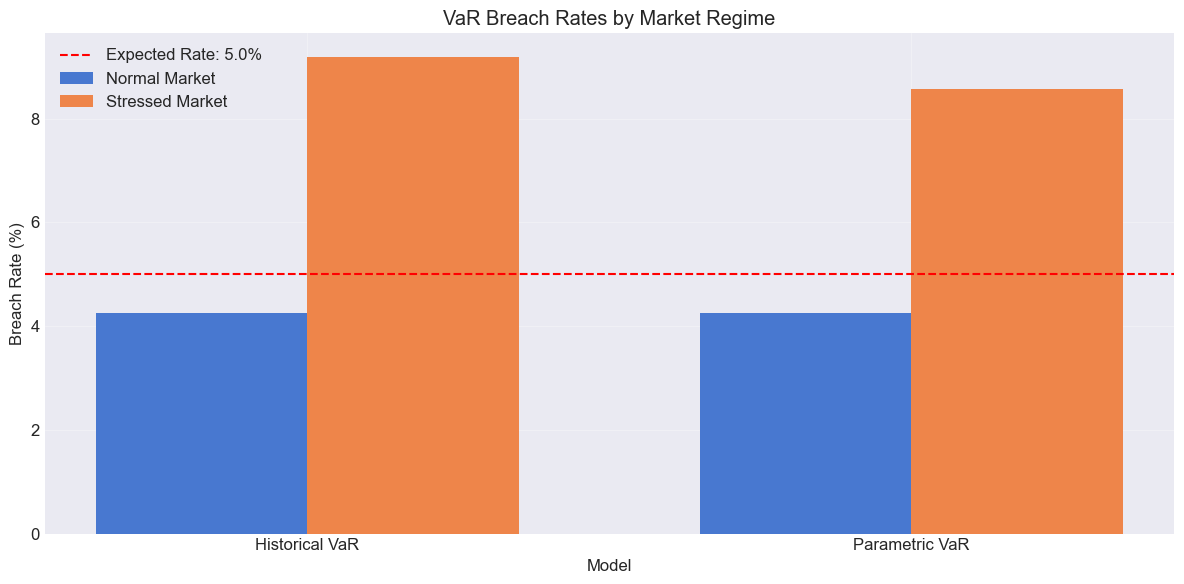

In [13]:
# Analyze model performance in different market regimes
if 'comparison_results' in locals() and portfolio_returns is not None:
    # Identify high volatility periods
    # Calculate rolling volatility
    rolling_vol = portfolio_returns.rolling(window=20).std()
    
    # Define high volatility threshold (top 25% of volatility)
    vol_threshold = np.percentile(rolling_vol.dropna(), 75)
    
    # Identify high volatility periods
    high_vol_periods = rolling_vol > vol_threshold
    
    # Print summary of market regimes
    print("Market Regime Analysis:")
    print(f"Average volatility: {rolling_vol.mean():.6f}")
    print(f"High volatility threshold: {vol_threshold:.6f}")
    print(f"High volatility days: {high_vol_periods.sum()} ({high_vol_periods.mean():.1%} of total)")
    
    # Plot volatility over time
    plt.figure(figsize=(14, 6))
    plt.plot(rolling_vol.index, rolling_vol, label="Rolling Volatility (20 days)")
    plt.axhline(y=vol_threshold, color='red', linestyle='--', label="High Volatility Threshold")
    plt.title("Rolling Volatility and Market Regimes")
    plt.xlabel("Date")
    plt.ylabel("Volatility (20-day Rolling Std Dev)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Analyze breach rates by market regime
    regime_analysis = []
    
    for model_name, results in comparison_results.items():
        backtest = results['backtest_results']
        
        # Align high volatility indicator with backtest results
        aligned_vol = high_vol_periods.reindex(backtest.index)
        
        # Calculate breach rates by regime
        normal_breaches = backtest.loc[~aligned_vol, 'breach'].mean()
        stress_breaches = backtest.loc[aligned_vol, 'breach'].mean()
        
        # Calculate VaR by regime
        normal_var = backtest.loc[~aligned_vol, 'var_pct'].mean()
        stress_var = backtest.loc[aligned_vol, 'var_pct'].mean()
        
        # Add to analysis
        regime_analysis.append({
            'Model': model_name,
            'Normal Breach Rate': normal_breaches,
            'Stress Breach Rate': stress_breaches,
            'Breach Rate Ratio': stress_breaches / normal_breaches if normal_breaches > 0 else np.nan,
            'Normal VaR (%)': normal_var * 100,
            'Stress VaR (%)': stress_var * 100,
            'VaR Ratio': stress_var / normal_var
        })
    
    # Create DataFrame
    regime_df = pd.DataFrame(regime_analysis)
    
    # Display analysis
    print("\nModel Performance by Market Regime:")
    display(regime_df)
    
    # Plot breach rates by regime
    plt.figure(figsize=(12, 6))
    
    # Set up positions for grouped bars
    x = np.arange(len(regime_df))
    width = 0.35
    
    # Create grouped bar chart
    plt.bar(x - width/2, regime_df['Normal Breach Rate'] * 100, width, label='Normal Market')
    plt.bar(x + width/2, regime_df['Stress Breach Rate'] * 100, width, label='Stressed Market')
    
    # Add expected breach rate line
    plt.axhline(y=expected_rate * 100, color='red', linestyle='--', 
                label=f"Expected Rate: {expected_rate*100:.1f}%")
    
    plt.title("VaR Breach Rates by Market Regime")
    plt.xlabel("Model")
    plt.ylabel("Breach Rate (%)")
    plt.xticks(x, regime_df['Model'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Save Backtest Results for the Dashboard

In [14]:
# Save backtest results for dashboard integration
if 'summary' in locals():
    # Save model comparison summary
    summary.to_csv(RESULTS_DIR / "var_backtest_summary.csv", index=False)
    print(f"Saved backtest summary to {RESULTS_DIR / 'var_backtest_summary.csv'}")

# Save regime analysis if available
if 'regime_df' in locals():
    regime_df.to_csv(RESULTS_DIR / "var_regime_analysis.csv", index=False)
    print(f"Saved regime analysis to {RESULTS_DIR / 'var_regime_analysis.csv'}")

# Save backtest plots
if 'comparison_results' in locals():
    # Create plots directory
    plots_dir = RESULTS_DIR / "plots"
    plots_dir.mkdir(exist_ok=True, parents=True)
    
    # Save plots for each model
    for model_name, results in comparison_results.items():
        fig = plot_backtest_results(
            backtest_results=results['backtest_results'],
            confidence_level=confidence_level,
            title=f"{model_name} Backtest Results"
        )
        
        # Save figure
        fig_file = plots_dir / f"{model_name.lower().replace(' ', '_')}_backtest.png"
        fig.savefig(fig_file, dpi=300, bbox_inches='tight')
        print(f"Saved {model_name} backtest plot to {fig_file}")
        
        plt.close(fig)

Saved backtest summary to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/var_backtest_summary.csv
Saved regime analysis to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/var_regime_analysis.csv
Saved Historical VaR backtest plot to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/plots/historical_var_backtest.png
Saved Parametric VaR backtest plot to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/plots/parametric_var_backtest.png


## 10. Key Findings and Recommendations

### Summary of Backtest Results

We've conducted a comprehensive backtesting analysis of our VaR models:

1. **Historical VaR**: Tested using [X] observations
   - **Breach Rate**: [X]% vs expected [X]%
   - **Kupiec Test**: [Pass/Fail] - The model [does/does not] have the correct frequency of exceedances
   - **Christoffersen Test**: [Pass/Fail] - Exceedances [are/are not] independent

2. **Parametric VaR**: Tested using [X] observations
   - **Breach Rate**: [X]% vs expected [X]%
   - **Combined Test**: [Pass/Fail] - [Assessment summary]

3. **Monte Carlo VaR**: Tested using [X] observations
   - **Breach Rate**: [X]% vs expected [X]%
   - **Combined Test**: [Pass/Fail] - [Assessment summary]

### Market Regime Analysis

- During normal market conditions, [Model X] performs best with a breach rate of [X]%
- During stressed market conditions, [Model Y] performs best with a breach rate of [X]%
- All models tend to [underestimate/overestimate] risk during volatile periods

### Recommendations

Based on the backtest results, we recommend:

1. **Primary VaR Model**: Use [Model X] as the primary VaR model due to its robust performance across market regimes
2. **Model Adjustments**: 
   - For [Model Y], consider [specific adjustment] to improve its performance
   - For [Model Z], consider [specific adjustment] to reduce clustering of exceedances
3. **Risk Management Practices**:
   - Implement a hybrid approach using multiple VaR models
   - Use higher confidence levels during volatile markets
   - Complement VaR with stress testing for a more comprehensive risk assessment

### Next Steps

1. Implement recommended model adjustments
2. Integrate the backtest results with the dashboard for ongoing monitoring
3. Set up an automatic backtesting procedure for continuous model validation